# 0.Импорт библиотек

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.Загрузка данных

In [38]:
df = pd.read_csv("Данные/df_out.csv.xz")
df.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


In [39]:
df.shape

(10000, 20)

Описание датасета:
- `id`— идентификатор записи;
- `url`— URL-записи о продаже;
- `region`— регион;
- `region_url`— URL региона;
- `price`— стоимость;
- `year`— год выпуска;
- `manufacturer`— производитель;
- `model`— модель;
- `condition`— состояние;
- `cylinders`— количество цилиндров;
- `fuel`— тип топлива;
- `odometer`— количество пройденных миль;
- `title_status`— статус;
- `transmission`— коробка передач;
- `VIN`— идентификационный номер;
- `drive`— тип привода;
- `size`— размер;
- `type`— кузов;
- `paint_color`— цвет;
- `image_url`— URL изображения;
- `description`— указанное описание;
- `county`— страна;
- `state`— штат;
- `lat`— широта;
- `long`— долгота;
- `posting_date`— дата размещения объявления о продаже;
- `price_category`— категория цены.

# 2.Data Preparation

##2.1.Иследование на пропуски

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

In [41]:
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
missing_columns = missing_values[missing_values.values > 0].index.tolist()

print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))
print('Пропуски имеются в',len(missing_columns),"колонках:", ", ".join(missing_columns))
print(f'Процент пропущенных значений:\n{missing_values}')

Количество полностью заполненных объектов из всей выборки: 9507
Процент полностью заполненных объектов из всей выборки: 95.07
Пропуски имеются в 11 колонках: title_status, model, long, lat, fuel, transmission, year, posting_date, description, image_url, date
Процент пропущенных значений:
title_status      1.66
model             1.28
long              0.98
lat               0.98
fuel              0.63
transmission      0.45
year              0.36
posting_date      0.02
description       0.02
image_url         0.02
date              0.02
url               0.00
odometer          0.00
manufacturer      0.00
state             0.00
price             0.00
region_url        0.00
region            0.00
price_category    0.00
id                0.00
dtype: float64


##2.2.Обработка пропусков

###2.2.1.Обработка пропусков в дате, URL изображении, описании, дате размещения объявления о продаже

In [42]:
#Обработка пропусков в дате
df.date.isna().sum()

2

In [43]:
df[df.date.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
6728,7315259025,https://nh.craigslist.org/cto/d/manchester-201...,new hampshire,https://nh.craigslist.org,3750,NaN,other,NaN,NaN,95674,NaN,NaN,NaN,NaN,nh,NaN,NaN,NaN,low,NaN
9388,7208549803,https://bellingham.craigslist.org/ctd/d/bellin...,bellingham,https://bellingham.craigslist.org,11999,NaN,other,NaN,NaN,95674,NaN,NaN,NaN,NaN,wa,NaN,NaN,NaN,medium,NaN


In [44]:
#Отработка пропусков путем удаления записей, так как в этих записях много пропусков(в том числе в других колонках) и они малоинформативны
df = df[df.date.notna()] #тем самым удаляем пропуски в других колонках
df.shape

(9998, 20)

In [45]:
print("Количество пропущенных значений в URL изображения:", df.image_url.isna().sum())
print("Количество пропущенных значений в описании:", df.description.isna().sum())
print("Количество пропущенных значений в дате размещения объявления о продаже:", df.posting_date.isna().sum())


Количество пропущенных значений в URL изображения: 0
Количество пропущенных значений в описании: 0
Количество пропущенных значений в дате размещения объявления о продаже: 0


###2.2.2.Обработка пропусков в годе выпуска

In [46]:
df.year.value_counts(dropna=False)

year
2018.0    810
2017.0    809
2016.0    745
2013.0    699
2015.0    668
         ... 
1927.0      1
1958.0      1
1941.0      1
1935.0      1
1954.0      1
Name: count, Length: 90, dtype: int64

In [47]:
df.year.describe()

count    9964.000000
mean     2010.927941
std         9.672040
min      1915.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

In [48]:
df[df.year.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
344,7304102133,https://wenatchee.craigslist.org/ctd/d/wenatch...,wenatchee,https://wenatchee.craigslist.org,35880,NaN,other,500,gas,13508,clean,automatic,https://images.craigslist.org/00J0J_6IMoEUzIIM...,2019 *Ram* *1500* Big Horn/Lone Star 4x2 Quad ...,wa,47.434493,-120.320759,2021-04-09T06:31:03-0700,high,2021-04-09 13:31:03+00:00
420,7316337069,https://lasvegas.craigslist.org/ctd/d/scottsda...,las vegas,https://lasvegas.craigslist.org,84995,NaN,other,Super Duty F-350 SRW,diesel,1268,clean,automatic,https://images.craigslist.org/00x0x_iQCC0Ef28S...,2020 *Ford* *Super Duty F-350 SRW* 1K MILES. B...,nv,33.458277,-111.925970,2021-05-03T11:31:39-0700,high,2021-05-03 18:31:39+00:00
425,7315662117,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,43900,NaN,other,Grand Caravan,NaN,21,clean,automatic,https://images.craigslist.org/00f0f_7AwipNocNH...,"2019 *Dodge* *Grand Caravan* SE - $43,900Call ...",co,39.674406,-104.998604,2021-05-02T01:11:33-0600,high,2021-05-02 07:11:33+00:00
702,7316199009,https://nashville.craigslist.org/ctd/d/nashvil...,nashville,https://nashville.craigslist.org,28498,NaN,other,olet Silverado 1500,NaN,59246,NaN,automatic,https://images.craigslist.org/00T0T_dZ7nOXskCS...,2019 *Chevrolet* *Silverado 1500* 2019 CHEVROL...,tn,36.138022,-86.732261,2021-05-03T10:00:40-0500,high,2021-05-03 15:00:40+00:00
893,7316840794,https://denver.craigslist.org/ctd/d/american-f...,denver,https://denver.craigslist.org,60900,NaN,other,F-150,gas,6110,clean,automatic,https://images.craigslist.org/01616_bpzSdSRTbx...,"2020 *Ford* *F-150* PLATINUM FX4 Truck - $60,9...",co,40.362248,-111.785947,2021-05-04T12:11:22-0600,high,2021-05-04 18:11:22+00:00
906,7311915616,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,67900,NaN,other,Odyssey,gas,21,clean,automatic,https://images.craigslist.org/00404_erlbeKWEkn...,2020 *Honda* *Odyssey* EX-L w/Navi/RES Automat...,co,39.674406,-104.998604,2021-04-24T10:41:06-0600,high,2021-04-24 16:41:06+00:00
1005,7306735187,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,38900,NaN,other,Grand Caravan,NaN,21,clean,automatic,https://images.craigslist.org/00F0F_3T6FM0XMZW...,"2019 *Dodge* *Grand Caravan* SE - $38,900Call ...",co,39.674406,-104.998604,2021-04-14T10:51:36-0600,high,2021-04-14 16:51:36+00:00
1217,7309954650,https://gainesville.craigslist.org/ctd/d/gaine...,gainesville,https://gainesville.craigslist.org,24975,NaN,other,CR-V,gas,44128,clean,automatic,https://images.craigslist.org/00000_2TUtAgLlCR...,"2019 *Honda* *CR-V* EX 2WD SUV - $24,975Call o...",fl,29.676827,-82.319202,2021-04-20T14:46:55-0400,high,2021-04-20 18:46:55+00:00
1319,7313865045,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,47900,NaN,other,a Sienna,gas,43701,clean,automatic,https://images.craigslist.org/00o0o_8XYp4Zygdj...,2018 *Toyota* *Sienna* LE Automatic Access Sea...,co,39.674406,-104.998604,2021-04-28T10:12:14-0600,high,2021-04-28 16:12:14+00:00
1845,7303344554,https://daytona.craigslist.org/ctd/d/new-smyrn...,daytona beach,https://daytona.craigslist.org,35850,NaN,other,Transit Cargo Van,gas,567,clean,automatic,https://images.craigslist.org/00a0a_d4XVrHnlxl...,"2020 *Ford* *Transit Cargo Van* T-250 148"" WB*...",fl,29.046240,-80.934561,2021-04-07T17:10:06-0400,high,2021-04-07 21:10:06+00:00


In [49]:
#Отработка пропусков путем удаления записей
df = df[df.year.notna()]
print("Количество пропущенных значений в year:", df.year.isna().sum())

Количество пропущенных значений в year: 0


###2.2.3.Обработка пропусков в типе топлива

In [50]:
df.fuel.value_counts(dropna=False)

fuel
gas         8379
other        729
diesel       650
hybrid       108
NaN           54
electric      44
Name: count, dtype: int64

In [51]:
df[df.fuel.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
32,7309910590,https://eugene.craigslist.org/ctd/d/eugene-200...,eugene,https://eugene.craigslist.org,4977,2001.0,toyota,camry solara 2dr cpe se v6 auto (natl),NaN,193242,clean,automatic,https://images.craigslist.org/00F0F_ebtJlxCQjv...,***Call Us for more information at: 541-228-94...,or,44.076513,-123.150156,2021-04-20T10:40:15-0700,low,2021-04-20 17:40:15+00:00
78,7314559074,https://eugene.craigslist.org/ctd/d/eugene-200...,eugene,https://eugene.craigslist.org,27977,2009.0,ford,"f-150 4wd supercrew 145"" platinum",NaN,79522,clean,automatic,https://images.craigslist.org/00L0L_khoMmqXaSJ...,***Call Us for more information at: 541-228-94...,or,44.076513,-123.150156,2021-04-29T15:15:30-0700,high,2021-04-29 22:15:30+00:00
275,7315141987,https://honolulu.craigslist.org/oah/ctd/d/fort...,hawaii,https://honolulu.craigslist.org,29888,2019.0,nissan,frontier crew cab 4x2 sv auto,NaN,10679,clean,automatic,https://images.craigslist.org/00F0F_d9wEXQuSyu...,***Call Us for more information at: 877-262-34...,hi,21.344376,-157.896975,2021-04-30T15:50:19-1000,high,2021-05-01 01:50:19+00:00
471,7316807613,https://eugene.craigslist.org/ctd/d/eugene-200...,eugene,https://eugene.craigslist.org,13436,2006.0,chevrolet,"silverado 1500 ext cab 143.5"" wb 4wd ls",NaN,172700,clean,automatic,https://images.craigslist.org/00l0l_35tV0gQdD8...,***Call Us for more information at: 541-228-94...,or,44.076513,-123.150156,2021-05-04T10:20:19-0700,medium,2021-05-04 17:20:19+00:00
1009,7314561306,https://cnj.craigslist.org/ctd/d/parlin-2000-c...,central NJ,https://cnj.craigslist.org,5894,2000.0,chevrolet,"s-10 ext cab 123"" wb ls",NaN,78740,clean,automatic,https://images.craigslist.org/00O0O_8vd70bT1rY...,***Call Us for more information at: 732-316-55...,nj,40.468650,-74.296990,2021-04-29T18:20:19-0400,low,2021-04-29 22:20:19+00:00
1279,7310297136,https://westernmass.craigslist.org/ctd/d/johns...,western massachusetts,https://westernmass.craigslist.org,6000,2008.0,other,IC IC,NaN,0,NaN,automatic,https://images.craigslist.org/00404_cBFpBKbfr2...,"2008 *IC* *IC* CE300 - $6,000Call Us Today! 85...",ma,43.008105,-74.352011,2021-04-21T10:11:05-0400,low,2021-04-21 14:11:05+00:00
1318,7310414739,https://nwct.craigslist.org/ctd/d/melville-200...,northwest CT,https://nwct.craigslist.org,11995,2007.0,gmc,c-7500 multiple uses perfect,NaN,50098,clean,automatic,https://images.craigslist.org/00T0T_jvsOAKSGAr...,2007 *GMC* *C-7500 MULTIPLE USES PERFECT* FOR ...,ct,40.681179,-73.430488,2021-04-21T13:18:41-0400,medium,2021-04-21 17:18:41+00:00
1686,7316342709,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,19942,2017.0,ram,"promaster cargo van 1500 low roof 118"" wb",NaN,88836,clean,automatic,https://images.craigslist.org/00707_6ZlIIpYmGf...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T14:40:24-0400,medium,2021-05-03 18:40:24+00:00
1847,7315151536,https://honolulu.craigslist.org/oah/ctd/d/fort...,hawaii,https://honolulu.craigslist.org,29988,2019.0,toyota,sienna le fwd 8-passenger (natl),NaN,18762,clean,automatic,https://images.craigslist.org/00R0R_dO0gtiRwLa...,***Call Us for more information at: 877-262-34...,hi,21.344376,-157.896975,2021-04-30T16:25:22-1000,high,2021-05-01 02:25:22+00:00


In [52]:
#Обработка пропусков путем заполнения на other
df.fuel = df.fuel.fillna('other')
print("Количество пропущенных значений в fuel:", df.fuel.isna().sum())

Количество пропущенных значений в fuel: 0


<ipython-input-52-e6725f720758>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fuel = df.fuel.fillna('other')


###2.2.4.Обработка пропусков в модели автомобиля

In [53]:
df.model.value_counts(dropna=False)

model
f-150                        151
NaN                          126
silverado 1500               110
1500                         100
camry                         77
                            ... 
sorrento lx v6                 1
sierra1500 crewcab 4x4         1
corolla se                     1
xc60 t6 inscription sport      1
a3 2.0t premium plus pzev      1
Name: count, Length: 3447, dtype: int64

In [54]:
df.model.describe()

count      9838
unique     3446
top       f-150
freq        151
Name: model, dtype: object

In [55]:
df[df.model.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
67,7316913641,https://ventura.craigslist.org/cto/d/camarillo...,ventura county,https://ventura.craigslist.org,3000,2005.0,rover,NaN,gas,165206,clean,automatic,https://images.craigslist.org/00S0S_b3yx6L4N2S...,2005 Range Rover HSE Changed Oil and now engi...,ca,34.219565,-119.001986,2021-05-04T13:11:15-0700,low,2021-05-04 20:11:15+00:00
142,7316550853,https://chicago.craigslist.org/chc/cto/d/midlo...,chicago,https://chicago.craigslist.org,3000,2006.0,jeep,NaN,gas,132000,clean,automatic,https://images.craigslist.org/01111_kNv3EKjH4H...,SUPER CLEAN 2006 JEEP LIBEERY RANAGADE 4X4 O...,il,41.618957,-87.726334,2021-05-03T20:33:40-0500,low,2021-05-04 01:33:40+00:00
151,7303575863,https://worcester.craigslist.org/ctd/d/fitchbu...,worcester / central MA,https://worcester.craigslist.org,7800,2007.0,gmc,NaN,gas,190000,clean,automatic,https://images.craigslist.org/00f0f_iWjiToqea2...,2007 gmc with plow leather loaded nice truck r...,ma,42.579600,-71.803100,2021-04-08T09:10:07-0400,low,2021-04-08 13:10:07+00:00
200,7315267860,https://gainesville.craigslist.org/ctd/d/kissi...,gainesville,https://gainesville.craigslist.org,19200,2012.0,ram,NaN,gas,121371,clean,automatic,https://images.craigslist.org/00W0W_hHV4D0Po0G...,2012 RAM 1500 Laramie Crew Cab 2WD Offered...,fl,28.329026,-81.404237,2021-05-01T10:05:17-0400,medium,2021-05-01 14:05:17+00:00
251,7316024407,https://reading.craigslist.org/ctd/d/paterson-...,reading,https://reading.craigslist.org,18695,2007.0,ram,NaN,diesel,220019,clean,automatic,https://images.craigslist.org/00n0n_jgq4eOvH7I...,2007 Dodge Ram 2500 SLT 4x4 Quad Cab Cummins D...,pa,40.894535,-74.152367,2021-05-02T21:06:09-0400,medium,2021-05-03 01:06:09+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9564,7314341390,https://desmoines.craigslist.org/cto/d/urbanda...,des moines,https://desmoines.craigslist.org,8000,2007.0,toyota,NaN,gas,85285,clean,automatic,https://images.craigslist.org/00K0K_aMoJgOIueB...,Toyota has been owned by non smoker with no pe...,ia,41.629500,-93.723000,2021-04-29T10:50:54-0500,low,2021-04-29 15:50:54+00:00
9616,7304358131,https://vermont.craigslist.org/ctd/d/salem-201...,vermont,https://vermont.craigslist.org,19944,2012.0,ram,NaN,gas,73082,clean,automatic,https://images.craigslist.org/00A0A_bfCaGJ20IX...,2012 RAM 1500 4WD REGULAR CAB SHORT BED 5.7 HE...,vt,42.788204,-71.233728,2021-04-09T16:24:23-0400,medium,2021-04-09 20:24:23+00:00
9670,7309686008,https://louisville.craigslist.org/cto/d/radcli...,louisville,https://louisville.craigslist.org,1600,2005.0,gmc,NaN,gas,52536,clean,automatic,https://images.craigslist.org/01111_99unV6cYER...,GMC Savana PRO AWD cargo van has been driven l...,ky,37.858900,-86.006900,2021-04-20T04:48:30-0400,low,2021-04-20 08:48:30+00:00
9926,7316447901,https://tulsa.craigslist.org/cto/d/tulsa-2017-...,tulsa,https://tulsa.craigslist.org,65000,2017.0,rover,NaN,gas,47000,clean,automatic,https://images.craigslist.org/00s0s_iGpmplDL99...,"2017 Range Rover HSE, supercharged V8, silver ...",ok,36.126200,-95.940800,2021-05-03T16:37:36-0500,high,2021-05-03 21:37:36+00:00


In [56]:
#Проверка содержат ли приизводители пустые значения
print("Количество пропущенных значений в manufacturer:", df[df.model.isna()].manufacturer.isna().sum())

Количество пропущенных значений в manufacturer: 0


In [57]:
check = df[df.model.isna()].index.tolist()

In [58]:
#Восстановление модели автомобиля из описания
for ind, row in df[df.model.isna()].iterrows():
    model = re.search(row.manufacturer + r'\s+(\S+)', row.description.lower()) #поиск модели авто в описании
    if model:
        df.loc[ind, "model"] = model.group(1)


In [59]:
#Проверка
for i in check:
    print(i,'|', df.manufacturer[i], df.model[i])

67 | rover hse
142 | jeep libeery
151 | gmc with
200 | ram 1500
251 | ram 2500
259 | chevrolet corvette
285 | ford nan
363 | hyundai 4
499 | gmc nan
503 | chevrolet nan
613 | dodge caravan
648 | ram van
784 | mercury custom
822 | ram nan
943 | ford nan
953 | lincoln mkx
1244 | subaru outback
1249 | chevrolet nan
1271 | chevrolet corvette
1426 | honda odyssey
1452 | chevrolet corvette
1620 | chevrolet corvette
1632 | porsche cayman
1756 | gmc nan
1758 | volkswagen beetle,
1936 | jaguar xke
1980 | volvo nan
2017 | honda cr-v
2184 | ford nan
2247 | ford nan
2290 | ram 2500
2309 | ram 2500
2568 | ram 2500
2618 | volkswagen dune
3015 | toyota nan
3021 | ford nan
3022 | bmw nan
3056 | rover transmission
3254 | chevrolet nan
3313 | chevrolet nan
3360 | ram 3500
3367 | mercedes-benz nan
3469 | chevrolet nan
3481 | volkswagen nan
3675 | lincoln mkz
3676 | dodge challenger
3772 | dodge challenger
4013 | rover range
4096 | dodge challenger
4327 | chevrolet corvette
4330 | dodge nan
4357 | ford sh

In [60]:
#Оставшиеся модели заполняюстся на other
df.model = df.model.fillna("other")
print("Количество пропущенных значений в model:", df.model.isna().sum())

Количество пропущенных значений в model: 0


###2.2.5.Обработка пропусков в статусе автомобиля

In [61]:
df.title_status.value_counts(dropna=False)

title_status
clean         9492
rebuilt        168
NaN            159
salvage         92
lien            35
missing         16
parts only       2
Name: count, dtype: int64

In [62]:
df.title_status.describe()

count      9805
unique        6
top       clean
freq       9492
Name: title_status, dtype: object

In [63]:
df[df.title_status.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
11,7316540706,https://cincinnati.craigslist.org/ctd/d/fairfi...,cincinnati,https://cincinnati.craigslist.org,4995,2012.0,fiat,500 pop,gas,59242,NaN,manual,https://images.craigslist.org/00Z0Z_jbUmVcYlwR...,"2012 Fiat 500 Pop FOR ONLY $102/mo!59,242 mi. ...",oh,39.297045,-84.563243,2021-05-03T21:03:32-0400,low,2021-05-04 01:03:32+00:00
187,7313570594,https://orangecounty.craigslist.org/ctd/d/coro...,orange county,https://orangecounty.craigslist.org,17900,2013.0,ram,1500 tradesman quad cab,gas,145499,NaN,automatic,https://images.craigslist.org/00H0H_1JFMPCYyW8...,2013 Ram 1500 Tradesman Quad Cab PRICED TO SEL...,ca,33.873436,-117.542806,2021-04-27T15:03:47-0700,medium,2021-04-27 22:03:47+00:00
245,7315211652,https://ocala.craigslist.org/ctd/d/riverview-2...,ocala,https://ocala.craigslist.org,40990,2019.0,toyota,sienna xle,gas,3700,NaN,automatic,https://images.craigslist.org/01111_grKNF8GrXz...,2019 Toyota Sienna - Wheelchair Accessible Han...,fl,27.849760,-82.364950,2021-05-01T06:35:56-0400,high,2021-05-01 10:35:56+00:00
286,7306702976,https://toledo.craigslist.org/ctd/d/chelsea-73...,toledo,https://toledo.craigslist.org,4592,2003.0,chevrolet,avalanche 1500,gas,268691,NaN,automatic,https://images.craigslist.org/00808_1IOMJuA4GL...,$73/mo - 2003 Chevrolet Avalanche 1500 BaseCre...,oh,42.300673,-84.024108,2021-04-14T12:03:01-0400,low,2021-04-14 16:03:01+00:00
312,7307609203,https://roseburg.craigslist.org/ctd/d/eugene-2...,roseburg,https://roseburg.craigslist.org,18450,2017.0,ford,mustang,gas,66049,NaN,automatic,https://images.craigslist.org/00505_4apF36sLbP...,"2017 Ford MUSTANG - $18,450 \tMayberry Motors ...",or,44.058499,-123.106176,2021-04-16T04:06:29-0700,medium,2021-04-16 11:06:29+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9740,7301707830,https://tricities.craigslist.org/ctd/d/bristol...,tri-cities,https://tricities.craigslist.org,8995,2013.0,honda,odyssey,gas,203112,NaN,automatic,https://images.craigslist.org/00u0u_bawW7HN8xW...,"2013 *Honda* *Odyssey* 5dr EX Van FWD - $8,995...",tn,36.541821,-82.234645,2021-04-04T13:12:27-0400,low,2021-04-04 17:12:27+00:00
9805,7313949726,https://harrisburg.craigslist.org/ctd/d/brockp...,harrisburg,https://harrisburg.craigslist.org,8900,2012.0,honda,accord,other,95674,NaN,NaN,https://images.craigslist.org/01212_dsfYRNhxfd...,Car Starz Call Sales at 717-401-4221 2012 Hond...,pa,41.261540,-78.704520,2021-04-28T14:25:32-0400,low,2021-04-28 18:25:32+00:00
9840,7314987181,https://nashville.craigslist.org/ctd/d/nashvil...,nashville,https://nashville.craigslist.org,20900,2014.0,lexus,rx 350,gas,70800,NaN,automatic,https://images.craigslist.org/00Q0Q_cGablAkoYV...,2014 *Lexus* *RX 350* 2014 LEXUS RX 350 SUV 1-...,tn,36.138022,-86.732261,2021-04-30T15:00:48-0500,medium,2021-04-30 20:00:48+00:00
9856,7309717260,https://savannah.craigslist.org/ctd/d/jacksonv...,savannah / hinesville,https://savannah.craigslist.org,11495,2006.0,lexus,gx 470,gas,242000,NaN,automatic,https://images.craigslist.org/00s0s_8xg4gw6aAg...,"2006 *Lexus* *GX 470* 4dr SUV 4WD - $11,495By ...",ga,30.513566,-81.621875,2021-04-20T08:01:49-0400,medium,2021-04-20 12:01:49+00:00


In [64]:
#Обработка пропусков путем заполнения статуса автомобиля самым популярным значением
df.title_status = df.title_status.fillna(df.title_status.mode()[0])
print("Количество пропущенных значений в title_status:", df.title_status.isna().sum())

Количество пропущенных значений в title_status: 0


###2.2.6.Обработка пропусков в долготе и широте

In [65]:
df[df.long.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
118,7312692841,https://tricities.craigslist.org/ctd/d/bmw-ser...,tri-cities,https://tricities.craigslist.org,17998,2012.0,bmw,5 series,gas,62665,clean,automatic,https://images.craigslist.org/00909_57Xyuj8AJH...,2012 BMW 5 Series 535i M Sport Heat & Cool Sea...,tn,NaN,NaN,2021-04-26T04:28:35-0400,medium,2021-04-26 08:28:35+00:00
126,7315526339,https://newjersey.craigslist.org/ctd/d/look-wh...,north jersey,https://newjersey.craigslist.org,22995,2014.0,bmw,7 series,gas,81085,clean,automatic,https://images.craigslist.org/00k0k_38TNTakyUf...,2014 BMW 7 Series 4dr Sdn 750Li xDrive AWD Aut...,nj,NaN,NaN,2021-05-01T17:49:09-0400,high,2021-05-01 21:49:09+00:00
502,7308641593,https://winstonsalem.craigslist.org/ctd/d/ford...,winston-salem,https://winstonsalem.craigslist.org,20998,2016.0,ford,transit cargo,gas,123825,clean,automatic,https://images.craigslist.org/00101_gwJT4WBNRo...,2016 Ford Transit Cargo Vans Work Van High Roo...,nc,NaN,NaN,2021-04-18T04:43:46-0400,medium,2021-04-18 08:43:46+00:00
567,7309282242,https://onslow.craigslist.org/ctd/d/mercedes-b...,jacksonville,https://onslow.craigslist.org,10810,2014.0,mercedes-benz,c-class,gas,124476,clean,automatic,https://images.craigslist.org/01414_6jNHxQwrKx...,2014 Mercedes Benz C Class C 250 Sport Coupe C...,nc,NaN,NaN,2021-04-19T12:06:28-0400,medium,2021-04-19 16:06:28+00:00
692,7314847134,https://atlanta.craigslist.org/atl/ctd/d/2008-...,atlanta,https://atlanta.craigslist.org,17900,2008.0,toyota,tundra,gas,96000,clean,automatic,https://images.craigslist.org/01313_6u7l4KgvV4...,Description: 2008 Toyota Tundra 5...,ga,NaN,NaN,2021-04-30T12:09:49-0400,medium,2021-04-30 16:09:49+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9154,7312710592,https://athensga.craigslist.org/ctd/d/bmw-x5-a...,athens,https://athensga.craigslist.org,14975,2013.0,bmw,x5,gas,97195,clean,automatic,https://images.craigslist.org/00i0i_kU6D0X9br2...,2013 BMW X5 xDrive35i Sport Activity Navigatio...,ga,NaN,NaN,2021-04-26T07:31:40-0400,medium,2021-04-26 11:31:40+00:00
9408,7311736404,https://raleigh.craigslist.org/ctd/d/lexus-nx-...,raleigh / durham / CH,https://raleigh.craigslist.org,28998,2018.0,lexus,nx 300,gas,19863,clean,automatic,https://images.craigslist.org/00Q0Q_j7S3aRy6Sw...,2018 Lexus NX 300 Navigation Sunroof Bluetooth...,nc,NaN,NaN,2021-04-24T00:54:33-0400,high,2021-04-24 04:54:33+00:00
9650,7315596665,https://newjersey.craigslist.org/ctd/d/wow-201...,north jersey,https://newjersey.craigslist.org,16495,2013.0,jeep,grand cherokee,other,90878,clean,automatic,https://images.craigslist.org/00v0v_awwo3NjD7Q...,2013 Jeep Grand Cherokee 4WD 4dr Laredo Automa...,nj,NaN,NaN,2021-05-01T20:53:57-0400,medium,2021-05-02 00:53:57+00:00
9668,7308677951,https://myrtlebeach.craigslist.org/ctd/d/ford-...,myrtle beach,https://myrtlebeach.craigslist.org,33647,2015.0,ford,f-250 super duty,diesel,153524,clean,automatic,https://images.craigslist.org/00f0f_1c0aGXmmCL...,2015 Ford F250 4x4 Truck Diesel Pickup Trucks ...,sc,NaN,NaN,2021-04-18T08:43:25-0400,high,2021-04-18 12:43:25+00:00


In [66]:
#Обработка пропусков долготы и широты путем заполнения медианным значением для каждого штата
df['long'] = df.groupby('state', group_keys=False)['long'].apply(lambda x: x.fillna(x.median()))
df['lat'] = df.groupby('state', group_keys=False)['lat'].apply(lambda x: x.fillna(x.median()))
print("Количество пропущенных значений в long:", df.long.isna().sum())
print("Количество пропущенных значений в lat:", df.lat.isna().sum())

Количество пропущенных значений в long: 0
Количество пропущенных значений в lat: 0


###2.2.7.Обработка пропусков в коробке передач

In [67]:
df.transmission.describe()

count          9921
unique            3
top       automatic
freq           7667
Name: transmission, dtype: object

In [68]:
df.transmission.value_counts(dropna=False)

transmission
automatic    7667
other        1623
manual        631
NaN            43
Name: count, dtype: int64

In [69]:
df[df.transmission.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
111,7305109580,https://grandrapids.craigslist.org/ctd/d/comst...,grand rapids,https://grandrapids.craigslist.org,12750,2013.0,lexus,es,gas,109382,clean,NaN,https://images.craigslist.org/00n0n_kACT1l7OCN...,2013 Lexus ES 350 4dr Sdn Offered by: Auto...,mi,43.059210,-85.688970,2021-04-11T09:41:58-0400,medium,2021-04-11 13:41:58+00:00
112,7314951119,https://southjersey.craigslist.org/ctd/d/chest...,south jersey,https://southjersey.craigslist.org,18199,2012.0,jeep,wrangler,other,130174,clean,NaN,https://images.craigslist.org/00I0I_gRmuXmqil1...,2012 Jeep Wrangler Unlimited Sport 4WD Off...,nj,40.135190,-74.703570,2021-04-30T14:58:56-0400,medium,2021-04-30 18:58:56+00:00
817,7308021604,https://southjersey.craigslist.org/ctd/d/maple...,south jersey,https://southjersey.craigslist.org,11999,2015.0,honda,civic,gas,79797,clean,NaN,https://images.craigslist.org/00b0b_aCqgRZ7sAx...,2015 Honda Civic EX Offered by: VIP Auto O...,nj,39.938023,-74.971461,2021-04-16T19:46:55-0400,medium,2021-04-16 23:46:55+00:00
931,7314781483,https://nh.craigslist.org/ctd/d/plaistow-2018-...,new hampshire,https://nh.craigslist.org,64990,2018.0,ram,3500,other,8853,clean,NaN,https://images.craigslist.org/00000_iHpXs2BVmN...,2018 RAM Ram Chassis 3500 Short Wheelbase (Dua...,nh,42.834977,-71.107791,2021-04-30T10:15:30-0400,high,2021-04-30 14:15:30+00:00
970,7315044723,https://poconos.craigslist.org/ctd/d/chesterfi...,poconos,https://poconos.craigslist.org,22699,2014.0,jeep,wrangler,gas,110493,clean,NaN,https://images.craigslist.org/00M0M_aFDXWIfug9...,2014 Jeep Wrangler Unlimited Sport 4WD Off...,pa,40.135190,-74.703570,2021-04-30T17:46:04-0400,high,2021-04-30 21:46:04+00:00
1156,7311083008,https://greenville.craigslist.org/ctd/d/greenv...,greenville / upstate,https://greenville.craigslist.org,9998,2013.0,volkswagen,jetta,diesel,96115,clean,NaN,https://images.craigslist.org/00F0F_9oq0KNmZIM...,2013 VOLKSWAGEN JETTA TDI Highline Offered...,sc,34.832550,-82.368350,2021-04-22T17:55:57-0400,medium,2021-04-22 21:55:57+00:00
1349,7303942891,https://wenatchee.craigslist.org/ctd/d/everett...,wenatchee,https://wenatchee.craigslist.org,4995,2005.0,honda,pilot,gas,261591,clean,NaN,https://images.craigslist.org/00S0S_aASnH27HDH...,2005 Honda Pilot EX Offered by: Corn Motor...,wa,47.912956,-122.235725,2021-04-08T16:52:48-0700,low,2021-04-08 23:52:48+00:00
1715,7310344536,https://roanoke.craigslist.org/ctd/d/roanoke-2...,roanoke,https://roanoke.craigslist.org,3995,2007.0,ford,mustang,gas,159342,clean,NaN,https://images.craigslist.org/00J0J_6BuTyEWqNQ...,2007 Ford Mustang V6 Deluxe Coupe Offered ...,va,37.335355,-79.859385,2021-04-21T11:30:46-0400,low,2021-04-21 15:30:46+00:00
1914,7307857568,https://fortmyers.craigslist.org/lee/ctd/d/for...,ft myers / SW florida,https://fortmyers.craigslist.org,17000,2012.0,jeep,grand cherokee,gas,116079,clean,NaN,https://images.craigslist.org/00000_gqxck1dkEu...,2012 Jeep Grand Cherokee Limited Offered b...,fl,26.498960,-81.819380,2021-04-16T14:46:41-0400,medium,2021-04-16 18:46:41+00:00
2023,7314592581,https://pueblo.craigslist.org/ctd/d/pueblo-200...,pueblo,https://pueblo.craigslist.org,8494,2004.0,ford,ranger,gas,156969,clean,NaN,https://images.craigslist.org/01212_6ixSUy4WCq...,2004 Ford Ranger Offered by: Discount Moto...,co,38.298339,-104.616024,2021-04-29T17:30:13-0600,low,2021-04-29 23:30:13+00:00


In [70]:
#Обработка пропусков путем заполнения на other
df.transmission = df.transmission.fillna('other')
print("Количество пропущенных значений в transmission:", df.transmission.isna().sum())

Количество пропущенных значений в transmission: 0


In [71]:
print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))

Количество полностью заполненных объектов из всей выборки: 9964
Процент полностью заполненных объектов из всей выборки: 100.0


##2.3.Преобразование типа данных

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9964 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9964 non-null   int64  
 1   url             9964 non-null   object 
 2   region          9964 non-null   object 
 3   region_url      9964 non-null   object 
 4   price           9964 non-null   int64  
 5   year            9964 non-null   float64
 6   manufacturer    9964 non-null   object 
 7   model           9964 non-null   object 
 8   fuel            9964 non-null   object 
 9   odometer        9964 non-null   int64  
 10  title_status    9964 non-null   object 
 11  transmission    9964 non-null   object 
 12  image_url       9964 non-null   object 
 13  description     9964 non-null   object 
 14  state           9964 non-null   object 
 15  lat             9964 non-null   float64
 16  long            9964 non-null   float64
 17  posting_date    9964 non-null   object

###2.3.1.Преобразование типа данных в годе выпуска автомобиля

In [73]:
df.year.describe()

count    9964.000000
mean     2010.927941
std         9.672040
min      1915.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

In [74]:
#Изменение типа данных для года выпуска на более подходящий целочисленный тип
df.year = df.year.astype(int)
df.year.dtype

dtype('int64')

###2.3.2.Преобразование типа данных в категориальных переменных

In [75]:
df.transmission = df.transmission.astype("category")
df.region = df.region.astype("category")
df.manufacturer = df.manufacturer.astype("category")
df.state = df.state.astype("category")
df.title_status = df.title_status.astype("category")

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9964 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              9964 non-null   int64   
 1   url             9964 non-null   object  
 2   region          9964 non-null   category
 3   region_url      9964 non-null   object  
 4   price           9964 non-null   int64   
 5   year            9964 non-null   int64   
 6   manufacturer    9964 non-null   category
 7   model           9964 non-null   object  
 8   fuel            9964 non-null   object  
 9   odometer        9964 non-null   int64   
 10  title_status    9964 non-null   category
 11  transmission    9964 non-null   category
 12  image_url       9964 non-null   object  
 13  description     9964 non-null   object  
 14  state           9964 non-null   category
 15  lat             9964 non-null   float64 
 16  long            9964 non-null   float64 
 17  posting_date    996

###2.3.3.Преобразование дат

In [77]:
df.date = pd.to_datetime(df.date, utc=True)
df.date

0      2021-04-17 16:30:50+00:00
1      2021-05-03 19:40:21+00:00
2      2021-04-28 10:52:20+00:00
3      2021-04-17 14:08:57+00:00
4      2021-05-03 22:32:06+00:00
                  ...           
9995   2021-04-10 20:33:57+00:00
9996   2021-05-03 13:36:30+00:00
9997   2021-04-22 19:14:01+00:00
9998   2021-04-14 14:14:42+00:00
9999   2021-04-24 17:50:49+00:00
Name: date, Length: 9964, dtype: datetime64[ns, UTC]

In [78]:
df.posting_date = pd.to_datetime(df.date, utc=True)
df.posting_date

0      2021-04-17 16:30:50+00:00
1      2021-05-03 19:40:21+00:00
2      2021-04-28 10:52:20+00:00
3      2021-04-17 14:08:57+00:00
4      2021-05-03 22:32:06+00:00
                  ...           
9995   2021-04-10 20:33:57+00:00
9996   2021-05-03 13:36:30+00:00
9997   2021-04-22 19:14:01+00:00
9998   2021-04-14 14:14:42+00:00
9999   2021-04-24 17:50:49+00:00
Name: posting_date, Length: 9964, dtype: datetime64[ns, UTC]

##2.4.Избавление от аномалий

###2.4.1.Выбросы в годе выпуска

In [79]:
df.year.describe() #описательные статистики

count    9964.000000
mean     2010.927941
std         9.672040
min      1915.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

Text(0.5, 1.0, 'Распределение года выпуска автомобиля')

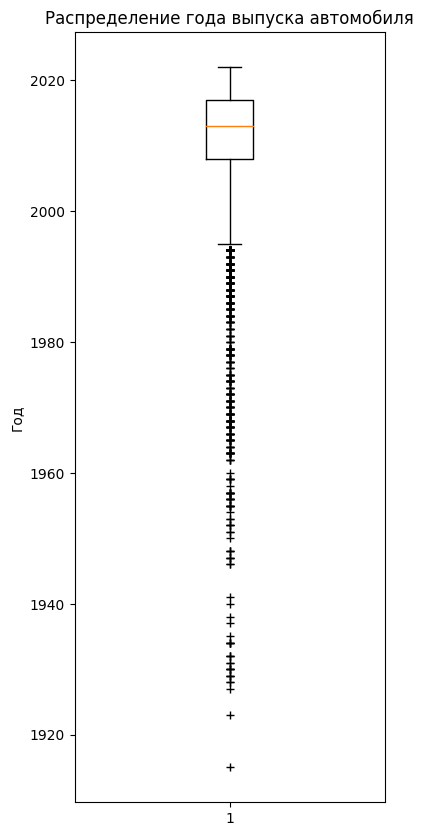

In [80]:
plt.figure(figsize=(4, 10)) #визуализация выбросов
plt.boxplot(df.year, sym='+')
plt.ylabel('Год')
plt.title('Распределение года выпуска автомобиля')

In [81]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [82]:
year_boundaries = calculate_outliers(df.year)
print(f"Границы для нормальных значений года выпуска:{year_boundaries}")

Границы для нормальных значений года выпуска:(1994.5, 2030.5)


In [83]:
year_outlier = (df.year < year_boundaries[0]) | (df.year > year_boundaries[1])
print(f"Количество выбросов в годе выпуска автомобиля:{year_outlier.sum()}")
print(f"Доля выбросов в годе выпуска автомобиля.:{year_outlier.sum()/len(df) * 100}")

Количество выбросов в годе выпуска автомобиля:394
Доля выбросов в годе выпуска автомобиля.:3.9542352468887993


In [84]:
df[year_outlier]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
13,7317089086,https://seattle.craigslist.org/see/ctd/d/portl...,seattle-tacoma,https://seattle.craigslist.org,14995,1994,ford,e-series van universal by glaval designer luxu...,gas,156925,clean,automatic,https://images.craigslist.org/00r0r_13JUlXZOMl...,"Priced to Sell: $14,9951994 Ford E-Series Van ...",wa,45.391373,-122.613533,2021-05-05 03:22:11+00:00,medium,2021-05-05 03:22:11+00:00
21,7312327909,https://madison.craigslist.org/cto/d/madison-1...,madison,https://madison.craigslist.org,89995,1970,other,oldsmobile 442,gas,111111,clean,automatic,https://images.craigslist.org/00S0S_agk7Nol4CO...,1970 Oldsmobile 442 Convertible 442 Indy Pace ...,wi,43.098400,-89.273400,2021-04-25 15:10:43+00:00,high,2021-04-25 15:10:43+00:00
57,7314413105,https://inlandempire.craigslist.org/ctd/d/cost...,inland empire,https://inlandempire.craigslist.org,69888,1948,ford,coe,gas,1,clean,automatic,https://images.craigslist.org/00M0M_8jgBCZZuG6...,Awesome Resto-Mod COE Ford Car Hauler. Equippe...,ca,33.680100,-117.908500,2021-04-29 17:49:29+00:00,high,2021-04-29 17:49:29+00:00
66,7310077530,https://hudsonvalley.craigslist.org/cto/d/bloo...,hudson valley,https://hudsonvalley.craigslist.org,5500,1990,other,Diahatsu,gas,30000,clean,manual,https://images.craigslist.org/00T0T_a4VRbx40ea...,1991 Daihatsu hijet 5 speed extended cab....im...,ny,41.564400,-74.430400,2021-04-20 22:30:18+00:00,low,2021-04-20 22:30:18+00:00
106,7314527175,https://rapidcity.craigslist.org/ctd/d/sherman...,rapid city / west SD,https://rapidcity.craigslist.org,43500,1968,chevrolet,camaro,gas,43320,clean,manual,https://images.craigslist.org/00h0h_2N66LMJBAI...,1968 Chevrolet Camaro Convertible. VIN:124678N...,sd,33.637200,-96.618400,2021-04-29 21:11:01+00:00,high,2021-04-29 21:11:01+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9886,7313487583,https://springfield.craigslist.org/cto/d/mount...,springfield,https://springfield.craigslist.org,3500,1974,jeep,cj5,gas,10000,clean,manual,https://images.craigslist.org/00G0G_cdxzaTaVqa...,1974 Jeep cj5 304 v8 4speed manual trans Da...,mo,36.331200,-92.375300,2021-04-27 19:30:28+00:00,low,2021-04-27 19:30:28+00:00
9921,7311566144,https://chico.craigslist.org/cto/d/chico-1994-...,chico,https://chico.craigslist.org,16000,1994,ford,f250,gas,32500,clean,automatic,https://images.craigslist.org/01010_343KkgTaHo...,"Up for sale is this 32,000 original mile Ford ...",ca,39.745800,-121.844400,2021-04-23 20:51:20+00:00,medium,2021-04-23 20:51:20+00:00
9944,7313676859,https://reno.craigslist.org/ctd/d/sherman-1984...,reno / tahoe,https://reno.craigslist.org,26500,1984,chevrolet,silverado,gas,38751,clean,automatic,https://images.craigslist.org/00r0r_czXfi4UeJF...,"1984 Chevrolet C10 Silverado, short wheelbase ...",ca,33.637200,-96.618400,2021-04-28 02:44:27+00:00,high,2021-04-28 02:44:27+00:00
9972,7316458200,https://portland.craigslist.org/mlt/cto/d/port...,portland,https://portland.craigslist.org,18500,1972,chevrolet,pick,gas,75000,clean,automatic,https://images.craigslist.org/00x0x_7FqS8iHJst...,1972 classic Chevrolet pick up custom deluxe ...,or,45.494960,-122.666988,2021-05-03 21:58:34+00:00,medium,2021-05-03 21:58:34+00:00


In [85]:
df.price[year_outlier].value_counts() #значения категории цены для записей, в которых год выпуска автомобиля является выбросом.

price
10000    13
5000     13
25000    11
9500     10
2500      8
         ..
13200     1
19000     1
39995     1
3499      1
1575      1
Name: count, Length: 176, dtype: int64

In [86]:
#значения, которые являются выбросами, заполняются значениями нижней границы,так как выбросы в годе выпуска находятся среди минимальных значений
df.loc[year_outlier, "year"] = int(year_boundaries[0])
df.year.describe().apply(lambda x: f"{x:0.2f}")

count    9964.00
mean     2011.67
std         6.52
min      1994.00
25%      2008.00
50%      2013.00
75%      2017.00
max      2022.00
Name: year, dtype: object

###2.4.2.Выбросы в стоимости автомобиля

In [87]:
df.price.describe() #описательные статистики

count    9.964000e+03
mean     2.059957e+04
std      1.248351e+05
min      5.000000e+02
25%      7.900000e+03
50%      1.559000e+04
75%      2.799000e+04
max      1.234568e+07
Name: price, dtype: float64

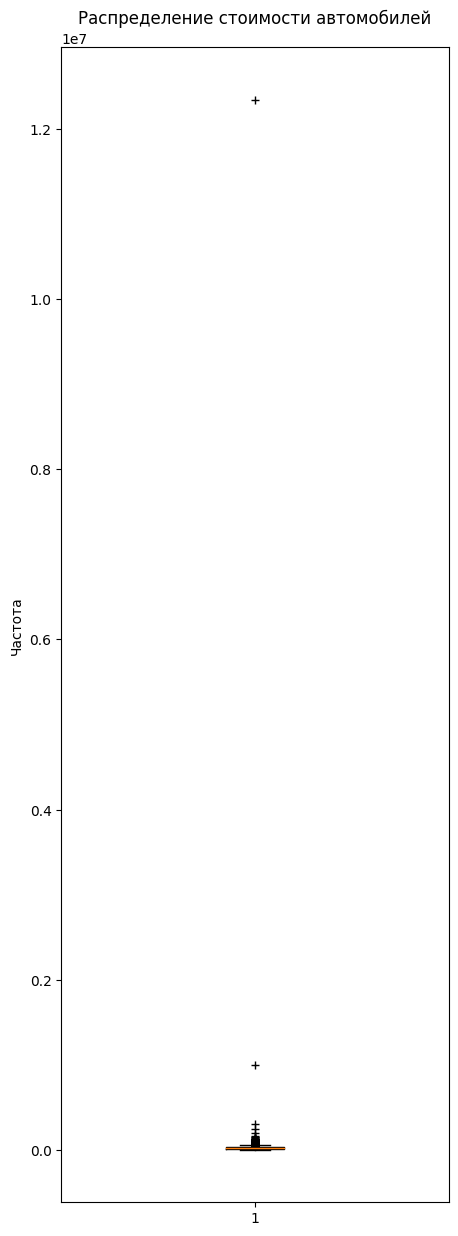

In [88]:
plt.figure(figsize=(5, 15)) #визуализация выбросов
plt.boxplot(df.price, sym="+")
plt.ylabel("Частота")
plt.title("Распределение стоимости автомобилей");

In [89]:
price_boundaries = calculate_outliers(df.price)
print(f'Нижняя граница: {price_boundaries[0]}, Верхняя граница: {price_boundaries[1]}')

Нижняя граница: -22235.0, Верхняя граница: 58125.0


In [90]:
price_outlier = (df.price < price_boundaries[0]) | (df.price > price_boundaries[1])
print(f'Количество выбросов: {price_outlier.sum()}')

Количество выбросов: 207


In [91]:
df[price_outlier].sort_values(['price'])

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
946,7312212565,https://lasvegas.craigslist.org/cto/d/fresno-d...,las vegas,https://lasvegas.craigslist.org,58500,2013,ram,3500 limited,diesel,57149,clean,automatic,https://images.craigslist.org/00o0o_6VEbwgYoL0...,Only 57K Miles! This 3500 RAM Truck has the 6....,nv,36.746400,-119.639700,2021-04-25 03:46:06+00:00,high,2021-04-25 03:46:06+00:00
6060,7310551940,https://cincinnati.craigslist.org/ctd/d/camp-d...,cincinnati,https://cincinnati.craigslist.org,58500,2019,chevrolet,"silverado 2500hd 4wd crew cab 153.7"" ltz",other,50930,clean,automatic,https://images.craigslist.org/01010_ldls5xr3zz...,***Call Us for more information at: 513-453-41...,oh,39.171991,-84.271999,2021-04-21 21:05:31+00:00,high,2021-04-21 21:05:31+00:00
4853,7308933629,https://omaha.craigslist.org/cto/d/cortland-20...,omaha / council bluffs,https://omaha.craigslist.org,58500,2008,chevrolet,corvette,gas,11000,clean,manual,https://images.craigslist.org/00P0P_kxzGxZwBY9...,2008 Corvette Z06 Wil Cooksey Edition Car nu...,ia,40.445488,-96.713695,2021-04-18 20:53:04+00:00,high,2021-04-18 20:53:04+00:00
8163,7307146509,https://lubbock.craigslist.org/ctd/d/brownfiel...,lubbock,https://lubbock.craigslist.org,58600,2019,ford,f-150,gas,29458,clean,automatic,https://images.craigslist.org/00E0E_6JF7CBAVf7...,Stanley CDJR Brownfield address: 1706 Lubbo...,tx,33.196047,-102.273565,2021-04-15 13:58:48+00:00,high,2021-04-15 13:58:48+00:00
1271,7313450196,https://lasvegas.craigslist.org/ctd/d/salem-20...,las vegas,https://lasvegas.craigslist.org,58670,2016,chevrolet,corvette,other,16407,clean,automatic,https://images.craigslist.org/00000_e7iiMwUVq3...,2016 *** Chevrolet Corvette 2LZ Z06*** ...,nv,44.927304,-123.030322,2021-04-27 18:29:39+00:00,high,2021-04-27 18:29:39+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6121,7315323093,https://daytona.craigslist.org/ctd/d/orlando-2...,daytona beach,https://daytona.craigslist.org,197999,2015,other,Lamborghini Huracan,gas,33875,clean,other,https://images.craigslist.org/01717_55Ai9omMq5...,CREDIT AMNESTY! SE HABLA ESPANOL !!OPEN SUNDA...,fl,28.466088,-81.396429,2021-05-01 15:48:44+00:00,high,2021-05-01 15:48:44+00:00
292,7310897583,https://tucson.craigslist.org/ctd/d/tucson-201...,tucson,https://tucson.craigslist.org,239995,2017,ferrari,488 gtb,gas,6012,clean,automatic,https://images.craigslist.org/00t0t_dN5Wr8nfOx...,2017 Ferrari 488 GTB Coupe2017 Ferrari 488 GTB...,az,32.236075,-110.878886,2021-04-22 16:38:59+00:00,high,2021-04-22 16:38:59+00:00
5662,7313998757,https://winchester.craigslist.org/ctd/d/manass...,winchester,https://winchester.craigslist.org,304995,2021,porsche,911,gas,22,clean,automatic,https://images.craigslist.org/00r0r_gh2TnrNdSu...,2021 PORSCHE 911 Turbo Offered by: Insider...,va,38.762669,-77.461754,2021-04-28 19:49:25+00:00,high,2021-04-28 19:49:25+00:00
9792,7305237859,https://delaware.craigslist.org/cto/d/delaware...,delaware,https://delaware.craigslist.org,1000000,2022,other,Any make any model,other,283466,clean,other,https://images.craigslist.org/00S0S_k3A68PVXRC...,We come to you and give you an easy quick tran...,de,39.572500,-75.595700,2021-04-11 17:51:42+00:00,high,2021-04-11 17:51:42+00:00


In [92]:
#Среди автомобилей с аномальной стоимостью присуствуют автомобили, высокую стоимость которых можно объяснить, в первучю очередь, производителем и низким пробегом.
#Удаление всех аномальных значений
df = df[~price_outlier]
df.shape

(9757, 20)

## 2.5.Иследование данных

###2.5.1.Исследование зависимости стоимости автомобиля от года производства

In [93]:
df_years = df.groupby(["year"], as_index = False).agg({"price":"mean"}).rename(columns = {"price":"price_mean"})
df_years #новый датафрейм, в котором будет содержаться статистика о годе производства автомобиля и среднем значении стоимости автомобиля за этот год

,year,price_mean
0,1994,13528.049223
1,1995,9610.060606
2,1996,9362.960000
3,1997,7213.666667
4,1998,6528.672727
5,1999,7387.536585
6,2000,7614.410256
7,2001,7987.430894
8,2002,7173.798658
9,2003,7767.962162


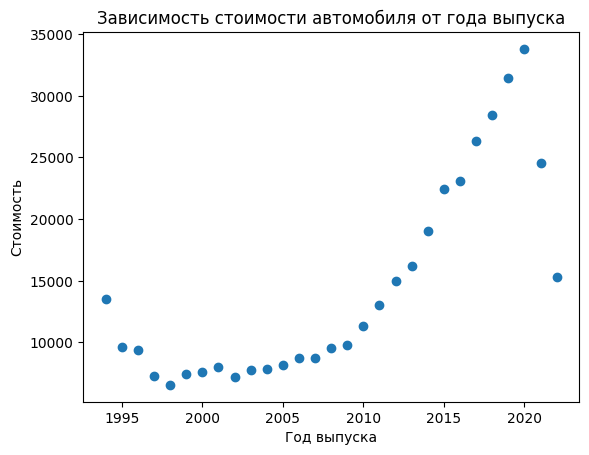

In [94]:
#диаграмма рассеяния
plt.figure()
plt.scatter(df_years["year"], df_years["price_mean"])
plt.title("Зависимость стоимости автомобиля от года выпуска")
plt.xlabel("Год выпуска")
plt.ylabel("Стоимость")

plt.show()

Из графика можно сделать вывод о возрастающем тренде: чем новее автомобиль, тем выше его цена. Исключение составляют наиболее старые и самые новые автомобили. Проверим, достаточно ли данных в выбивающихся из тренда значениях по годам. Для этого выведем количество автомобилей, произведенных в каждый год.

In [95]:
df_count = df.groupby(["year"]).count()[["id"]].rename(columns = {"id":"count"})
df_count

,count
year,
1994,386
1995,33
1996,25
1997,45
1998,55
1999,82
2000,78
2001,123
2002,149


In [96]:
#За последние два года мало накопленной информации — исключим их из исследования
df = df[df.year < 2021]
df.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17 16:30:50+00:00,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03 19:40:21+00:00,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28 10:52:20+00:00,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17 14:08:57+00:00,medium,2021-04-17 14:08:57+00:00
5,7303797340,https://knoxville.craigslist.org/ctd/d/knoxvil...,knoxville,https://knoxville.craigslist.org,14590,2012,bmw,1 series 128i coupe 2d,other,80465,clean,other,https://images.craigslist.org/00F0F_5UAXmOzC18...,Carvana is the safer way to buy a car During t...,tn,35.970000,-83.940000,2021-04-08 19:10:56+00:00,medium,2021-04-08 19:10:56+00:00


In [97]:
#Формированию нового датафрейма на отфильтрованных данных
df_years_filtered = df.groupby(["year"], as_index = False).agg({"price":"mean"}).rename(columns = {"price":"price_mean"})
df_years_filtered

,year,price_mean
0,1994,13528.049223
1,1995,9610.060606
2,1996,9362.960000
3,1997,7213.666667
4,1998,6528.672727
5,1999,7387.536585
6,2000,7614.410256
7,2001,7987.430894
8,2002,7173.798658
9,2003,7767.962162


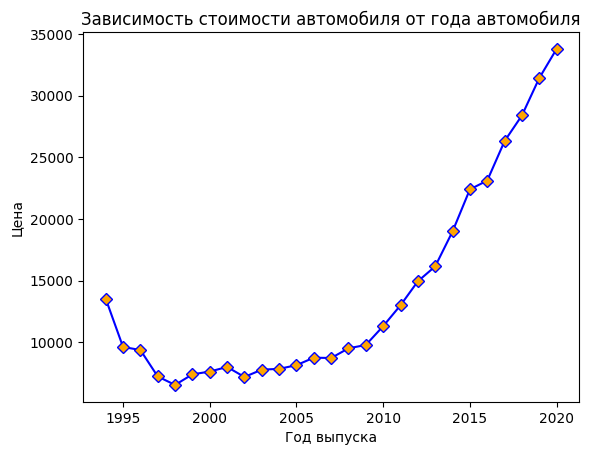

In [98]:
#График для визуализации зависимости стоимости от года выпуска автомобиля
plt.figure()
plt.plot(df_years_filtered.year, df_years_filtered.price_mean, color="blue", marker="D", markerfacecolor="orange")
plt.xlabel("Год выпуска")
plt.ylabel("Цена")
plt.title("Зависимость стоимости автомобиля от года автомобиля");

In [99]:
 #коэффициент корреляции Пирсона для стоимости автомобиля и года его производства
 df_years_filtered.corr()

,year,price_mean
year,1.000000,0.822803
price_mean,0.822803,1.000000


Так как коэффициент корреляции больше 0,7, можно сделать вывод о сильной корреляции между стоимостью автомобиля и годом его производства.Существующая связь является прямой и линейной.

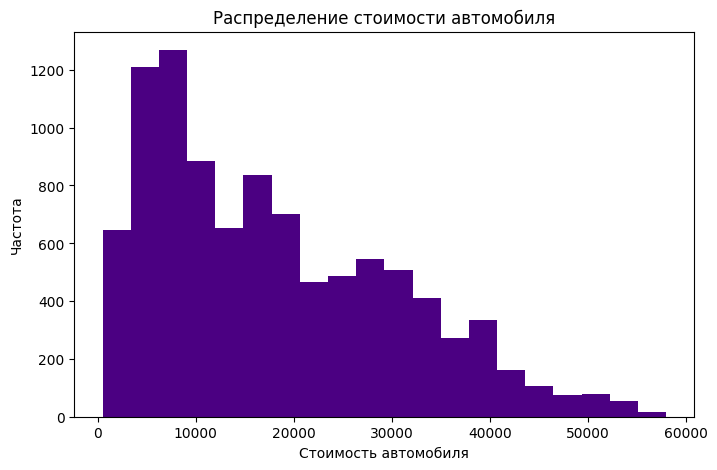

In [100]:
#гистограмма распределения стоимости автомобиля
plt.figure(figsize = (8, 5))
plt.hist(df.price, bins=20, color="indigo")
plt.xlabel("Стоимость автомобиля")
plt.ylabel("Частота")
plt.title("Распределение стоимости автомобиля");

### 2.5.2.Исследование зависимости ценовой категории автомобилиля от стоимости и года производства

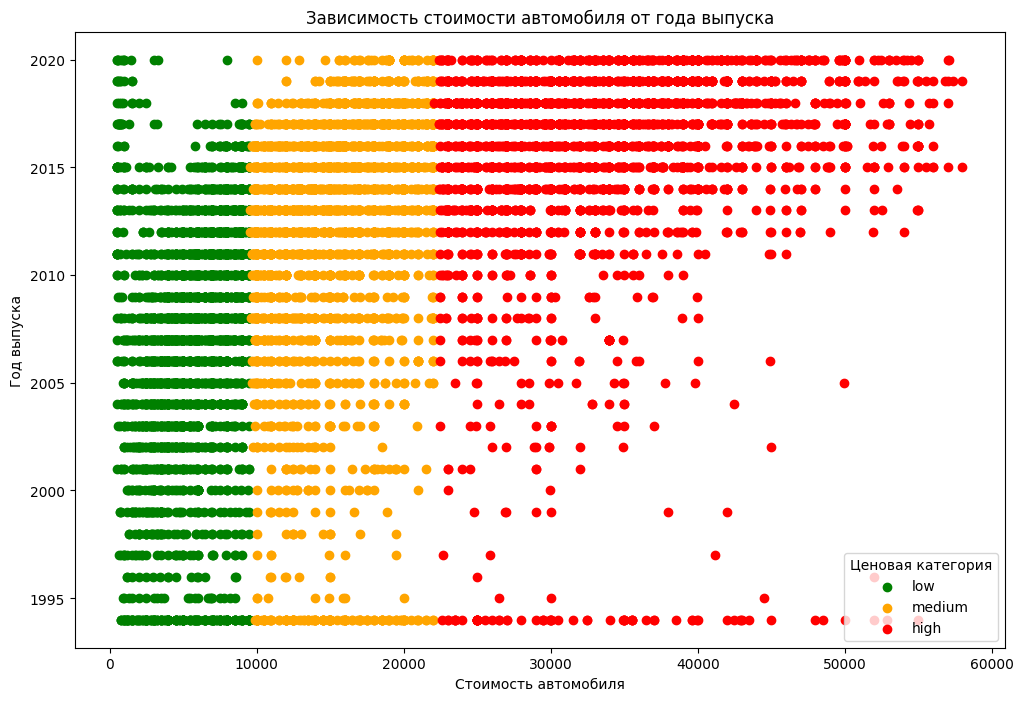

In [101]:
#график распределения стоимости автомобиля для каждой из ценовой категории автомобиля
colors={"low":"green", "medium":"orange","high":"red"}
fig, ax = plt.subplots(figsize=(12, 8))

for price_category in colors:
    color = colors[price_category]
    data = df[df["price_category"] == price_category]
    ax.scatter(data["price"], data["year"], c=color)
ax.legend(colors,loc="lower right", title="Ценовая категория")
plt.title("Зависимость стоимости автомобиля от года выпуска")
plt.xlabel("Стоимость автомобиля")
plt.ylabel("Год выпуска")
plt.show()

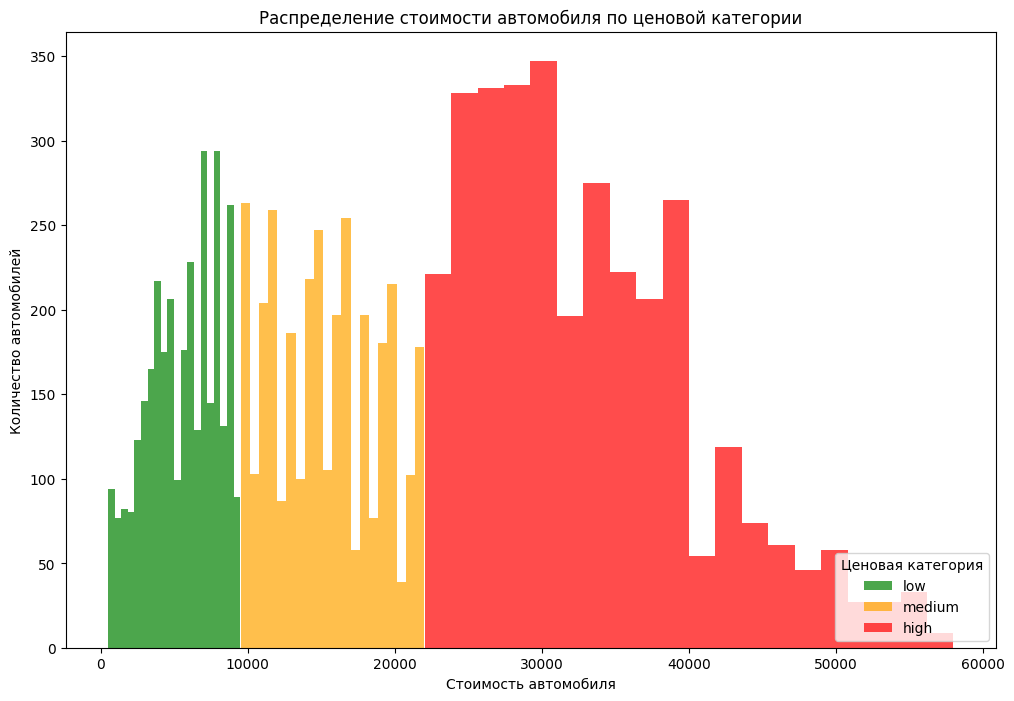

In [102]:
#диаграммf рассеяния для стоимости автомобиля и его года выпуска.
colors={"low":"green", "medium":"orange","high":"red"}
fig, ax = plt.subplots(figsize=(12, 8))

for price_category in colors:
    color = colors[price_category]
    data = df[df["price_category"] == price_category]
    ax.hist(data["price"], bins=20, color=color, alpha = 0.7)
ax.legend(colors, loc="lower right", title="Ценовая категория")
plt.title("Распределение стоимости автомобиля по ценовой категории")
plt.xlabel("Стоимость автомобиля")
plt.ylabel("Количество автомобилей")
plt.show()

###2.5.3.Визуализация категориальных переменных

In [103]:
#новый датафрейм, в котором содержаться статистика о производителе автомобиля и количестве произведенных им автомобилей
df_stats = df.groupby(["manufacturer"], as_index=False)[["id"]].count().rename(columns = {"id":"count"})
df_stats

,manufacturer,count
0,acura,150
1,alfa-romeo,14
2,audi,194
3,bmw,326
4,buick,144
5,cadillac,177
6,chevrolet,1244
7,chrysler,160
8,datsun,2
9,dodge,321


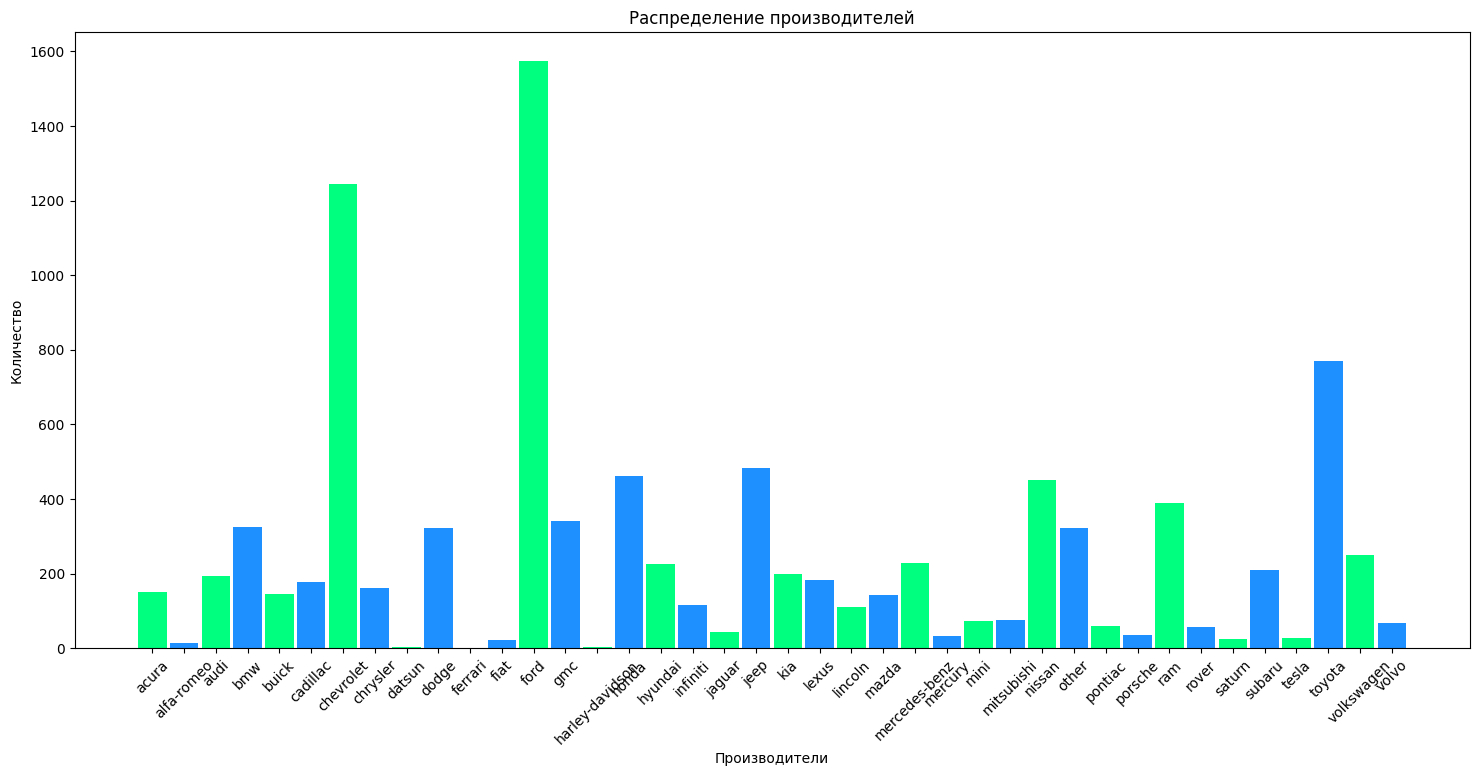

In [104]:
#столбчатая диаграмма производителей автомобиля
plt.figure(figsize = (18, 8))
plt.bar(df_stats['manufacturer'], df_stats['count'], width=0.9, color=['springgreen','dodgerblue'])
plt.xlabel('Производители')
plt.xticks(rotation=45)
plt.ylabel('Количество')
plt.title('Распределение производителей');

In [105]:
#новый датафрейм, в котором содержатся статистика о коробке передач автомобиля и количестве автомобилей с такой коробкой передач
df_trans = df.groupby(["transmission"], as_index=False)[["id"]].count().rename(columns = {"id":"count"})
df_trans

,transmission,count
0,automatic,7451
1,manual,617
2,other,1645


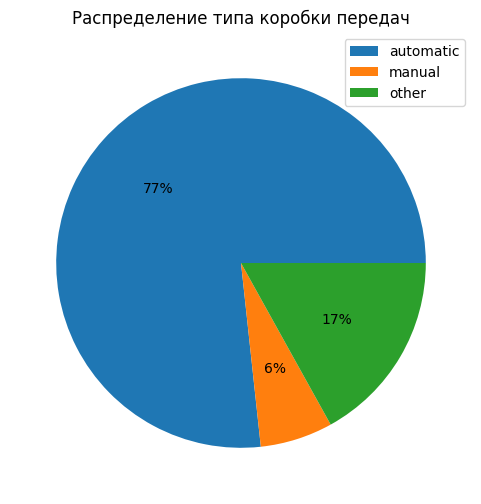

In [106]:
#круговая диаграмма для коробки передач автомобиля
plt.figure(figsize = (6, 6))
plt.pie(df_trans['count'], labels=df_trans['transmission'], labeldistance=None, autopct = '%1.0f%%')
plt.legend()
plt.title('Распределение типа коробки передач')
plt.show()

# 3.Feature Engineering

##3.1.Генерация дополнительных фичей

In [107]:
#список значений и количество уникальных значений для модели автомобиля
df.model.value_counts()

model
f-150                        148
silverado 1500               107
1500                         105
camry                         77
silverado                     72
                            ... 
xc60 t6 inscription sport      1
silverado 1500 ls              1
silverado diesel 3500          1
q50 2.0t luxe sedan 4d         1
a3 2.0t premium plus pzev      1
Name: count, Length: 3375, dtype: int64

In [108]:
#сокращение уникальных значений, оставляя только первое слово в наименовании модели
df['short_model'] = df["model"].apply(lambda x: x.split(" ")[0])
df.short_model.value_counts()

short_model
silverado    394
1500         211
wrangler     206
grand        202
f-150        200
            ... 
maximum        1
slk            1
sle            1
classuc        1
durangon       1
Name: count, Length: 966, dtype: int64

In [109]:
#создание нового признака, обозначающего возрастную категорию:
#new-старше 2013;
#average-между 2006 и 2013;
#old-до 2006
df['age_category'] =  df.apply(lambda x: "new" if x.year > 2013 else "old" if x.year < 2006 else "average", axis=1)
df[['year', 'age_category']]

,year,age_category
0,2020,new
1,2016,new
2,2017,new
3,2013,average
5,2012,average
...,...,...
9995,2002,old
9996,2008,average
9997,2011,average
9998,2015,new


In [110]:
#создание нового признака, обозначающего пробег в км
df['odometer_km'] = df.apply(lambda x: x.odometer  * 1.609344, axis=1)
df['odometer_km']

0        44163.618048
1        96597.654912
2        22608.064512
3       188761.567104
5       129495.864960
            ...      
9995    241401.600000
9996    182778.026112
9997    241697.719296
9998     99687.595392
9999     57809.245824
Name: odometer_km, Length: 9713, dtype: float64

In [111]:
#создание нового признака, обозначающего количество символов в описании
df['desc_len'] = df.apply(lambda x: len(x.description) , axis=1)
df['desc_len']

0       4482
1        968
2       4286
3       3241
5       4851
        ... 
9995    1710
9996     948
9997     909
9998    3644
9999    4483
Name: desc_len, Length: 9713, dtype: int64

In [112]:
#создание нового признака, обозначающего количество символов в модели
df['model_len'] = df.apply(lambda x: len(x.model) , axis=1)
df['model_len']

0       22
1       20
2       16
3        4
5       22
        ..
9995     4
9996     8
9997    25
9998     7
9999    22
Name: model_len, Length: 9713, dtype: int64

In [113]:
#создание нового признака, обозначающего количество слов в модели автомобиля
df['model_word_count'] = df.apply(lambda x: len(x.model.split(' ')), axis=1)
df['model_word_count']

0       5
1       4
2       3
3       1
5       5
       ..
9995    1
9996    1
9997    5
9998    1
9999    5
Name: model_word_count, Length: 9713, dtype: int64

In [114]:
#создание нового признака, обозначающего сколько раз встречается модель в описании
df['model_in_desc'] = df.apply(lambda x: x.description.count(x.model) , axis=1)
df['model_in_desc']

0       0
1       0
2       0
3       0
5       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: model_in_desc, Length: 9713, dtype: int64

In [115]:
#создание нового признака, обозначающего номер месяца размещения объявления
df['month'] = df.posting_date.dt.month
df.month

0       4
1       5
2       4
3       4
5       4
       ..
9995    4
9996    5
9997    4
9998    4
9999    4
Name: month, Length: 9713, dtype: int32

In [116]:
#создание нового признака, обозначающий день недели размещения объявления о продаже автомобиля
df['dayofweek'] = df.posting_date.dt.weekday
df.dayofweek

0       5
1       0
2       2
3       5
5       3
       ..
9995    5
9996    0
9997    3
9998    2
9999    5
Name: dayofweek, Length: 9713, dtype: int32

In [117]:
#создание нового признака, обозначающий количество лет между годом производства автомобиля и годом размещения объявления о продаже автомобиля
df['diff_years'] = df.posting_date.dt.year - df.year
df.diff_years

0        1
1        5
2        4
3        8
5        9
        ..
9995    19
9996    13
9997    10
9998     6
9999     4
Name: diff_years, Length: 9713, dtype: int64

In [118]:
#создание для каждого выбранного производителя автомобиля отдельного признака, содержащего 1, если данный автомобиль произведён именно этим производителем, и 0, если нет.
manufacturer_names = df.manufacturer.unique()
for manufacturer in manufacturer_names:
    col_name = 'is_' + manufacturer

    df[col_name] = df.apply(lambda x: 1 if x.manufacturer == manufacturer else 0, axis=1)

##3.2.Преобразование категориальных переменных

In [119]:
#создание датафрейма, содержащего только категориальные переменные
data = df[['fuel', 'short_model', 'transmission', 'region', 'manufacturer', 'state', 'title_status', 'age_category']]
data

,fuel,short_model,transmission,region,manufacturer,state,title_status,age_category
0,diesel,2500,other,chattanooga,ram,tn,clean,new
1,other,explorer,automatic,north jersey,ford,nj,clean,new
2,gas,golf,other,reno / tahoe,volkswagen,ca,clean,new
3,gas,rav4,automatic,fayetteville,toyota,nc,clean,average
5,other,1,other,knoxville,bmw,tn,clean,average
...,...,...,...,...,...,...,...,...
9995,gas,rav4,automatic,chautauqua,toyota,ny,clean,old
9996,gas,wrangler,other,binghamton,jeep,ny,clean,average
9997,gas,a3,automatic,salem,audi,or,clean,average
9998,hybrid,cayenne,automatic,madison,porsche,wi,clean,new


In [120]:
#создание объекта класса OneHotEncoder и преобразование
ohe = OneHotEncoder(sparse=False)
ohe.fit(data)
ohe_data = ohe.transform(data)
df[ohe.get_feature_names_out()] = ohe_data

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-120-dc984f27f19d>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe_data
<ipython-input-120-dc984f27f19d>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe_data
<ipython-input

In [121]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,state_wy,title_status_clean,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,age_category_average,age_category_new,age_category_old
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,7303797340,https://knoxville.craigslist.org/ctd/d/knoxvil...,knoxville,https://knoxville.craigslist.org,14590,2012,bmw,1 series 128i coupe 2d,other,80465,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##3.3.Стандартизация данных

In [122]:
quant_vars = ['odometer', 'lat', 'long', 'year', 'desc_len', 'model_in_desc', 'model_len', 'model_word_count']
std_data = df[quant_vars]

In [123]:
#создание класса StandartScaler и стандартизация
std_scaler = StandardScaler()
std_scaler.fit(std_data)
scaler_data = std_scaler.transform(std_data)

In [124]:
quant_var_std = []
for quant_var in quant_vars:
    col_name = quant_var + "_std"
    quant_var_std.append(col_name)
quant_var_std

['odometer_std',
 'lat_std',
 'long_std',
 'year_std',
 'desc_len_std',
 'model_in_desc_std',
 'model_len_std',
 'model_word_count_std']

In [125]:
df[quant_var_std] = scaler_data
df.head()

<ipython-input-125-406942322fca>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[quant_var_std] = scaler_data
<ipython-input-125-406942322fca>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[quant_var_std] = scaler_data
<ipython-input-125-406942322fca>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.c

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,age_category_new,age_category_old,odometer_std,lat_std,long_std,year_std,desc_len_std,model_in_desc_std,model_len_std,model_word_count_std
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,1.0,0.0,-1.081088,-0.617706,0.478488,1.308223,0.625488,-0.160705,1.170772,1.920395
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,1.0,0.0,-0.560529,0.391761,1.105992,0.690663,-0.652549,-0.160705,0.939273,1.243588
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,1.0,0.0,-1.295089,-0.842100,0.525499,0.845053,0.554203,-0.160705,0.476274,0.566781
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.0,0.0,0.354464,-0.502783,0.848365,0.227492,0.174138,-0.160705,-0.912722,-0.786832
5,7303797340,https://knoxville.craigslist.org/ctd/d/knoxvil...,knoxville,https://knoxville.craigslist.org,14590,2012,bmw,1 series 128i coupe 2d,other,80465,...,0.0,0.0,-0.233919,-0.458275,0.551962,0.073102,0.759693,-0.160705,1.170772,1.920395


##3.4.Признаки на основе дат

In [126]:
month_scaler= StandardScaler()
df[['dayofweek_std', 'diff_years_std', 'month_std']]=month_scaler.fit(df[['dayofweek', 'diff_years', 'month']]).transform(df[['dayofweek', 'diff_years', 'month']])
df

<ipython-input-126-b863e2311742>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['dayofweek_std', 'diff_years_std', 'month_std']]=month_scaler.fit(df[['dayofweek', 'diff_years', 'month']]).transform(df[['dayofweek', 'diff_years', 'month']])
<ipython-input-126-b863e2311742>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['dayofweek_std', 'diff_years_std', 'month_std']]=month_scaler.fit(df[['dayofweek', 'diff_years', 'month']]).transform(df[['dayofweek', 'diff_years', 'month']])
<ipython-input-126-b863e2311742>:2: Perfor

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,lat_std,long_std,year_std,desc_len_std,model_in_desc_std,model_len_std,model_word_count_std,dayofweek_std,diff_years_std,month_std
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,-0.617706,0.478488,1.308223,0.625488,-0.160705,1.170772,1.920395,1.116032,-1.308223,-0.613962
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,0.391761,1.105992,0.690663,-0.652549,-0.160705,0.939273,1.243588,-1.373294,-0.690663,1.628765
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,-0.842100,0.525499,0.845053,0.554203,-0.160705,0.476274,0.566781,-0.377564,-0.845053,-0.613962
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,-0.502783,0.848365,0.227492,0.174138,-0.160705,-0.912722,-0.786832,1.116032,-0.227492,-0.613962
5,7303797340,https://knoxville.craigslist.org/ctd/d/knoxvil...,knoxville,https://knoxville.craigslist.org,14590,2012,bmw,1 series 128i coupe 2d,other,80465,...,-0.458275,0.551962,0.073102,0.759693,-0.160705,1.170772,1.920395,0.120302,-0.073102,-0.613962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7304876387,https://chautauqua.craigslist.org/ctd/d/falcon...,chautauqua,https://chautauqua.craigslist.org,4495,2002,toyota,rav4,gas,150000,...,0.619888,0.818403,-1.470799,-0.382685,-0.160705,-0.912722,-0.786832,1.116032,1.470799,-0.613962
9996,7316152972,https://binghamton.craigslist.org/ctd/d/roches...,binghamton,https://binghamton.craigslist.org,14495,2008,jeep,wrangler,gas,113573,...,0.811397,0.898826,-0.544459,-0.659823,-0.160705,-0.449723,-0.786832,-1.373294,0.544459,1.628765
9997,7310993818,https://salem.craigslist.org/ctd/d/salem-2011-...,salem,https://salem.craigslist.org,8995,2011,audi,a3 2.0t premium plus pzev,gas,150184,...,1.110799,-1.637832,-0.081288,-0.674007,-0.160705,1.518021,1.920395,0.120302,0.081288,-0.613962
9998,7306637427,https://madison.craigslist.org/ctd/d/madison-2...,madison,https://madison.craigslist.org,31900,2015,porsche,cayenne,hybrid,61943,...,0.778559,0.245850,0.536273,0.320709,-0.160705,-0.565473,-0.786832,-0.377564,-0.536273,-0.613962


In [127]:
columns_for_drop = ['year', 'url', 'region_url', 'manufacturer',
                    'model', 'fuel', 'odometer', 'title_status', 'transmission',
                    'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
                    'odometer_km','desc_len', 'model_in_desc',  'age_category',
                    'model_len', 'model_word_count', 'short_model', 'date', 'region',
                    'month', 'dayofweek', 'diff_years','price','id'
                    ]

In [128]:
df_prepared = df.drop(columns=columns_for_drop)
df_prepared

,price_category,is_ram,is_ford,is_volkswagen,is_toyota,is_bmw,is_honda,is_dodge,is_nissan,is_mitsubishi,...,lat_std,long_std,year_std,desc_len_std,model_in_desc_std,model_len_std,model_word_count_std,dayofweek_std,diff_years_std,month_std
0,high,1,0,0,0,0,0,0,0,0,...,-0.617706,0.478488,1.308223,0.625488,-0.160705,1.170772,1.920395,1.116032,-1.308223,-0.613962
1,medium,0,1,0,0,0,0,0,0,0,...,0.391761,1.105992,0.690663,-0.652549,-0.160705,0.939273,1.243588,-1.373294,-0.690663,1.628765
2,high,0,0,1,0,0,0,0,0,0,...,-0.842100,0.525499,0.845053,0.554203,-0.160705,0.476274,0.566781,-0.377564,-0.845053,-0.613962
3,medium,0,0,0,1,0,0,0,0,0,...,-0.502783,0.848365,0.227492,0.174138,-0.160705,-0.912722,-0.786832,1.116032,-0.227492,-0.613962
5,medium,0,0,0,0,1,0,0,0,0,...,-0.458275,0.551962,0.073102,0.759693,-0.160705,1.170772,1.920395,0.120302,-0.073102,-0.613962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,low,0,0,0,1,0,0,0,0,0,...,0.619888,0.818403,-1.470799,-0.382685,-0.160705,-0.912722,-0.786832,1.116032,1.470799,-0.613962
9996,medium,0,0,0,0,0,0,0,0,0,...,0.811397,0.898826,-0.544459,-0.659823,-0.160705,-0.449723,-0.786832,-1.373294,0.544459,1.628765
9997,low,0,0,0,0,0,0,0,0,0,...,1.110799,-1.637832,-0.081288,-0.674007,-0.160705,1.518021,1.920395,0.120302,0.081288,-0.613962
9998,high,0,0,0,0,0,0,0,0,0,...,0.778559,0.245850,0.536273,0.320709,-0.160705,-0.565473,-0.786832,-0.377564,-0.536273,-0.613962


Описание преобразованного датасета:
- `is_manufacturer_name`— признак производителя автомобиля;
- `region_*`— регион;
- `fuel_*`— тип топлива;
- `manufacturer_*`— производитель;
- `short_model_*`— сокращённая модель автомобиля;
- `title_status_*`— статус;
- `transmission_*`— коробка передач;
- `state_*`— штат;
- `age_category_*`— возрастная категория автомобиля;
- `odometer_std`— количество пройденных миль (после стандартизации);
- `year_std`— год выпуска (после стандартизации);
- `lat_std`— широта (после стандартизации);
- `long_std`— долгота (после стандартизации);
- `desc_len_std`— количество символов в тексте объявления о продаже (после стандартизации);
- `model_in_desc_std`— количество наименований модели автомобиля в тексте объявления о продаже (после стандартизации);
- `model_len_std`— длина наименования автомобиля (после стандартизации);
- `model_word_count_std`— количество слов в наименовании автомобиля (после стандартизации);
- `month_std`— номер месяца размещения объявления о продаже автомобиля (после стандартизации);
- `dayofweek_std`— день недели размещения объявления о продаже автомобиля (после стандартизации);
- `diff_years_std`— количество лет между годом производства автомобиля и годом размещения объявления о продаже автомобиля (после стандартизации);
- `price_category`– категория цены.

# 4.Modeling

In [129]:
#датасет для обучения
x = df_prepared.drop(['price_category'], axis=1)
y = df_prepared['price_category']

#разделение данных на тренировочные и тестовые
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## 4.1.Случайный лес

In [130]:
#обучение модели
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(x_train, y_train)

#предикт
pred_train_rf = rf_clf.predict(x_train)
pred_test_rf = rf_clf.predict(x_test)

#точность
print(f'accuracy на тренировочной выборке:{accuracy_score(y_train, pred_train_rf)}')
print(f'accuracy на тестовой выборке:{accuracy_score(y_test, pred_test_rf)}')

accuracy на тренировочной выборке:1.0
accuracy на тестовой выборке:0.7628689087165408


In [131]:
#тюнинг модели
rf_clf_tuned = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf_tuned.fit(x_train, y_train)

#предикт
pred_train_rf_tuned = rf_clf_tuned.predict(x_train)
pred_test_rf_tuned = rf_clf_tuned.predict(x_test)

#точность
print(f'accuracy на тренировочной выборке:{accuracy_score(y_train, pred_train_rf_tuned)}')
print(f'accuracy на тестовой выборке:{accuracy_score(y_test, pred_test_rf_tuned)}')

accuracy на тренировочной выборке:1.0
accuracy на тестовой выборке:0.769732326698696


## 4.2.Логистическая регрессия

In [132]:
#обучение модели
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [133]:
#предикт
pred_train_logreg = logreg.predict(x_train)
pred_test_logreg = logreg.predict(x_test)

#точность
print(f'accuracy на тренировочной выборке:{accuracy_score(y_train, pred_train_logreg)}')
print(f'accuracy на тестовой выборке:{accuracy_score(y_test, pred_test_logreg)}')

accuracy на тренировочной выборке:0.8554199146933372
accuracy на тестовой выборке:0.7659574468085106


In [134]:
#тюнинг модели
logreg_tuned = LogisticRegression(penalty='l2', solver='newton-cg', random_state=42)
logreg_tuned.fit(x_train, y_train)

#предикт
pred_train_logreg_tuned = logreg_tuned.predict(x_train)
pred_test_logreg_tuned = logreg_tuned.predict(x_test)

#точность
print(f'accuracy на тренировочной выборке:{accuracy_score(y_train, pred_train_logreg_tuned)}')
print(f'accuracy на тестовой выборке:{accuracy_score(y_test, pred_test_logreg_tuned)}')

accuracy на тренировочной выборке:0.8554199146933372
accuracy на тестовой выборке:0.7645847632120796


## 4.3.Многослойный персептрон

In [135]:
#обучение модели
mlp=MLPClassifier(random_state=42)
mlp.fit(x_train, y_train)

#предикт
pred_train_mlp = mlp.predict(x_train)
pred_test_mlp = mlp.predict(x_test)

#точность
print(f'accuracy на тренировочной выборке:{accuracy_score(y_train, pred_train_mlp)}')
print(f'accuracy на тecтовой выборке:{accuracy_score(y_test, pred_test_mlp)}')

accuracy на тренировочной выборке:0.9998529195469922
accuracy на тecтовой выборке:0.7687028140013726


In [136]:
#тюнинг модели
mlp_tuned=MLPClassifier(activation="logistic", hidden_layer_sizes=200, random_state=42)
mlp_tuned.fit(x_train, y_train)

#предикт
pred_train_mlp_tuned = mlp_tuned.predict(x_train)
pred_test_mlp_tuned = mlp_tuned.predict(x_test)

#точность
print(f'accuracy на тренировочной выборке:{accuracy_score(y_train, pred_train_mlp_tuned)}')
print(f'accuracy на тecтовой выборке:{accuracy_score(y_test, pred_test_mlp_tuned)}')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


accuracy на тренировочной выборке:0.9394028533607883
accuracy на тecтовой выборке:0.7752230610844201


# 5.Result

In [137]:
#проверка метрики точности каждой из модели
for model in (rf_clf_tuned, logreg_tuned, mlp_tuned):
    cv_score = cross_val_score(model, x, y, cv=5)
    print(f"{model} имеет среднее: {cv_score.mean()} и среднеквадратическое отклонение:{cv_score.std()}")


RandomForestClassifier(n_estimators=200, random_state=42) имеет среднее: 0.7741155368793308 и среднеквадратическое отклонение:0.00859197619434248
LogisticRegression(random_state=42, solver='newton-cg') имеет среднее: 0.7739101466989424 и среднеквадратическое отклонение:0.005602090356387058


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=200, random_state=42) имеет среднее: 0.7942949233377838 и среднеквадратическое отклонение:0.007005866431598962


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Многослойный персептрон выигрывает в значении метрики, среднеквадратическое отклонение во всех случаях небольшое.

In [138]:
#обучение на полном датасете
mlp_tuned.fit(x, y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=200, random_state=42)

In [139]:
#сохранение модели
filename="model.pickle"

with open(filename, 'wb') as file:
    pickle.dump(mlp_tuned, file)